## The SARIMA(p,d,q)(P,D,Q)m model

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

Seasonal autoregressive integrated moving average (SARIMA) model  
The seasonal autoregressive integrated moving average (SARIMA) model adds seasonal parameters to the ARIMA(p,d,q) model.
It is denoted as SARIMA(p,d,q)(P,D,Q)m, where P is the order of the seasonal AR(P)
process, D is the seasonal order of integration, Q is the order of the seasonal MA(Q)
process, and m is the frequency, or the number of observations per seasonal cycle.
Note that a SARIMA(p,d,q)(0,0,0)m model is equivalent to an ARIMA(p,d,q) model.

In [2]:
df = pd.read_csv('../data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


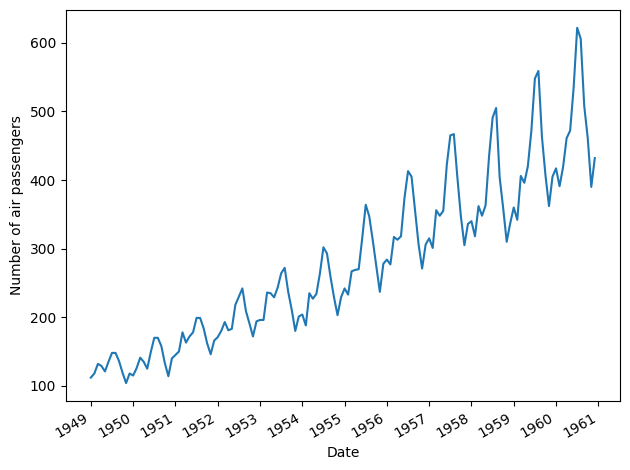

In [3]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

## Identifying seasonal patterns in a time series

1. Plotting the time series data to observe periodic patterns

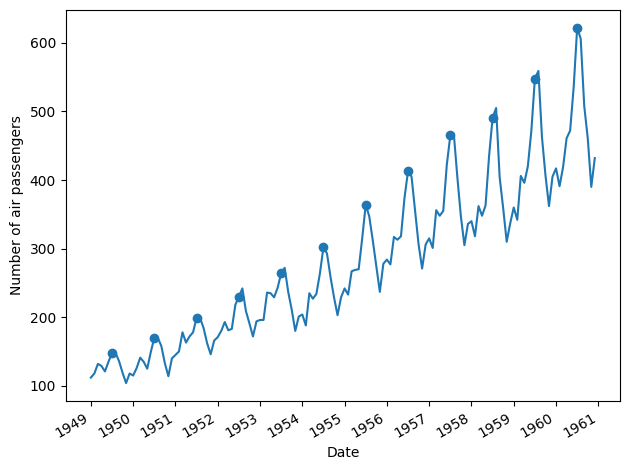

In [4]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

2. Time series decomposition    
Time series decomposition is a statistical task that separates the time series into its
three main components: a trend component, a seasonal component, and the residuals.
The trend component represents the long-term change in the time series. This component is responsible for time series that increase or decrease over time. The seasonal component is the periodic pattern in the time series. It represents repeated fluctuations that occur over a fixed period of time. Finally, the residuals, or the noise, express any irregularity that cannot be explained by the trend or the seasonal component.

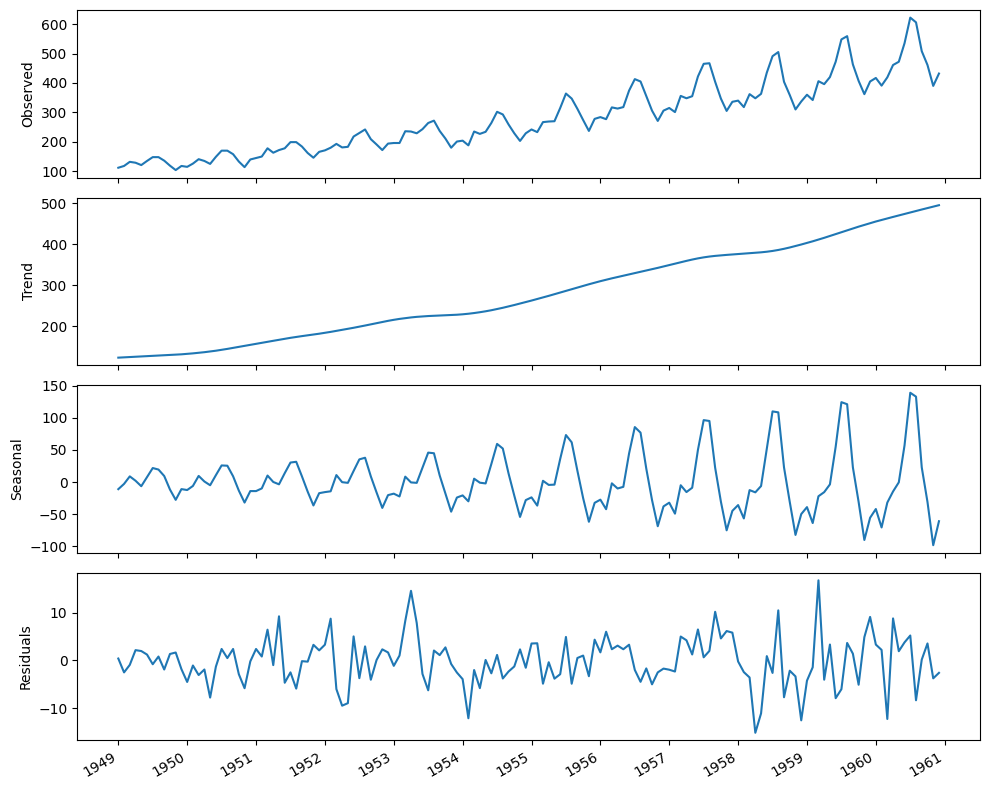

In [5]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting the number of monthly air passengers

In [6]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060668
p-value: 0.9918802434376413


We cannot reject the null hypothesis, therefore the series is not stationary.

In [7]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241699994
p-value: 0.0542132902838255


We still cannot reject the null hypothesis, therefore the series is not stationary.

In [8]:
df_diff2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468545
p-value: 2.732891850013967e-29


Differencing a second time: We can reject the null hypothesis so d=2

In [9]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0] #using ARIMA here
Qs = [0]

d = 2
D = 0
s = 12 #this is equivalent to m in the SARIMA model implementation

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [10]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
train = df['Passengers'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.847469
1,"(11, 4, 0, 0)",1019.018692
2,"(11, 5, 0, 0)",1020.379653
3,"(11, 1, 0, 0)",1021.024910
4,"(12, 0, 0, 0)",1021.049244
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


In [12]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.424
Date:                Mon, 27 Nov 2023   AIC                           1016.847
Time:                        13:09:42   BIC                           1059.860
Sample:                             0   HQIC                          1034.325
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8245      0.100     -8.232      0.000      -1.021      -0.628
ar.L2         -0.9621      0.049    -19.707      0.000      -1.058      -0.866
ar.L3         -0.8519      0.087     -9.766      0.0

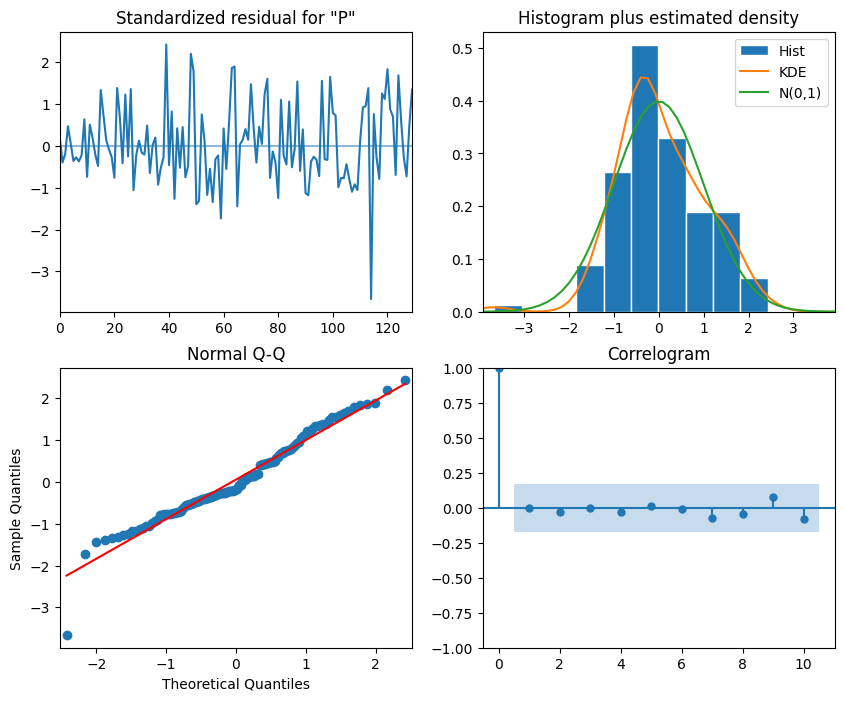

In [13]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [16]:
residuals = ARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [20]:
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,6.548506,0.010497
2,6.674825,0.035529
3,6.944271,0.073695
4,7.743574,0.101436
5,8.389420,0.136040
6,8.677706,0.192531
7,9.495873,0.218986
8,9.732803,0.284283
9,9.742638,0.371719
10,11.525349,0.318078


We see that the first 2 p-values are less than 0.05, so we reject the null hypothesis?
We also see that the remainining values are greater than 0.05.

This means that our ARIMA model is not capturing all the information about the data

### Naive approach

In [21]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [30]:
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test


,Month,Passengers,naive_seasonal,SARIMA_pred,ARIMA_pred
132,1960-01,417,360,418.518580,422.256156
133,1960-02,391,342,399.578852,410.622031
134,1960-03,419,406,461.313250,461.783709
135,1960-04,461,396,451.434244,457.685954
136,1960-05,472,420,473.748731,481.563464
137,1960-06,535,472,538.782469,530.887615
138,1960-07,622,548,612.476298,606.096305
139,1960-08,606,559,624.667804,615.412645
140,1960-09,508,463,520.181986,525.678915
141,1960-10,461,407,462.850848,467.195571


### Forecasting with a SARIMA model

In [22]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.253658
1,"(2, 1, 2, 1)",893.713533
2,"(2, 1, 1, 3)",894.106863
3,"(1, 0, 1, 2)",894.289315
4,"(0, 1, 1, 2)",894.991590
...,...,...
250,"(0, 0, 2, 0)",906.940147
251,"(3, 2, 0, 3)",907.181875
252,"(0, 0, 3, 2)",907.446519
253,"(0, 0, 3, 0)",908.742583


In [23]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.127
Date:                                 Mon, 27 Nov 2023   AIC                            892.254
Time:                                         14:28:31   BIC                            911.708
Sample:                                              0   HQIC                           900.153
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2666      0.085    -14.977      0.000      -1.432      -1

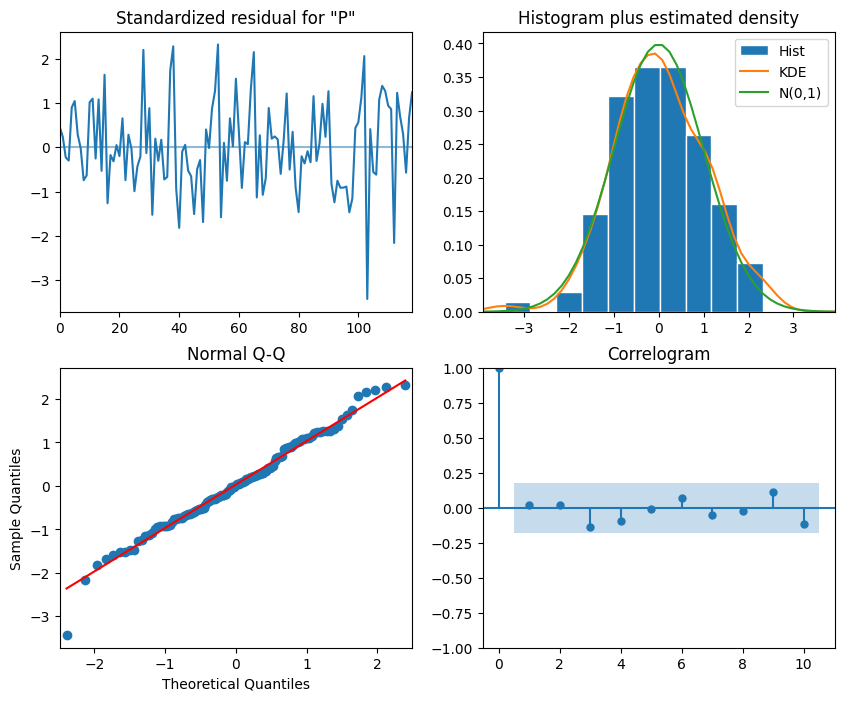

In [24]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [28]:
residuals = SARIMA_model_fit.resid

values = acorr_ljungbox(residuals, np.arange(1, 11, 1))

values

,lb_stat,lb_pvalue
1,0.004801,0.944758
2,0.745919,0.688693
3,1.022001,0.795929
4,1.226646,0.873692
5,1.436605,0.920268
6,1.712321,0.944166
7,2.308128,0.940840
8,2.717717,0.950805
9,2.733991,0.973915
10,4.968989,0.893240


In [29]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,naive_seasonal,SARIMA_pred
132,1960-01,417,360,418.518580
133,1960-02,391,342,399.578852
134,1960-03,419,406,461.313250
135,1960-04,461,396,451.434244
136,1960-05,472,420,473.748731
137,1960-06,535,472,538.782469
138,1960-07,622,548,612.476298
139,1960-08,606,559,624.667804
140,1960-09,508,463,520.181986
141,1960-10,461,407,462.850848


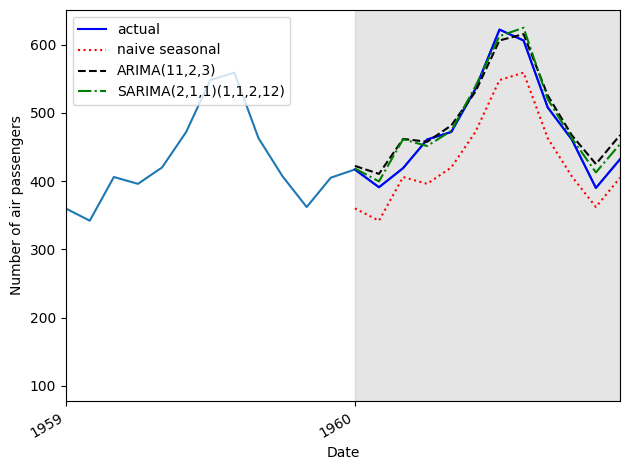

In [31]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

In [32]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

9.987532920823485 3.840898946066116 2.849655176763483


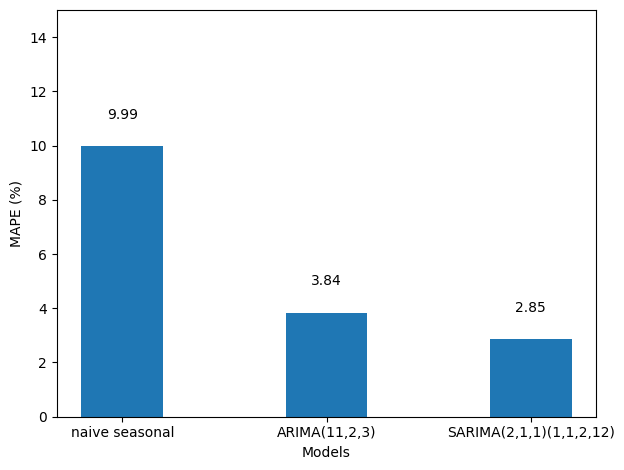

In [34]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()